### IMPORTS 

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

%matplotlib inline

from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import io
import requests
import shutil
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers
from sklearn import metrics

### HELPER FUNCTION

In [7]:

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)
    
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

    # Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
  

def to_sequences(seq_size, data1, data2):
    x = []
    y = []

    for i in range(len(data1)-seq_size):
        #print(i)
        window = data1[i:(i+seq_size)]
        after_window = data2[i+seq_size]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x), np.array(y)


### LOAD THE DATA CSV  FILE

In [8]:

path = "/Users/pavan/Desktop/ai 2nd pro"
csvfile = os.path.join(path,"CSC215_P2_Stock_Price.csv") 
df_stock = pd.read_csv(csvfile)

#print first and last 5 rows in new csv file
print(df_stock.head())
print(df_stock.tail())

print("\nNumber of columns and row currently:")
print("Data: ", df_stock.shape)


        Date      Open      High       Low     Close  Adj_Close   Volume
0  2000/3/27  3.812500  4.156250  3.812500  4.125000   4.125000  3675600
1  2000/3/28  4.125000  4.125000  4.000000  4.015625   4.015625  1077600
2  2000/3/29  4.000000  4.031250  3.953125  4.000000   4.000000   437200
3  2000/3/30  4.000000  4.000000  3.843750  3.843750   3.843750  1883600
4  2000/3/31  3.734375  3.734375  3.390625  3.390625   3.390625  7931600
          Date        Open        High         Low       Close   Adj_Close  \
4387  2017/9/1  113.790001  114.099998  112.790001  113.309998  113.309998   
4388  2017/9/5  112.519997  113.529999  111.160004  111.870003  111.870003   
4389  2017/9/6  112.029999  112.489998  110.250000  112.230003  112.230003   
4390  2017/9/7  112.459999  112.900002  112.000000  112.339996  112.339996   
4391  2017/9/8  112.300003  114.790001  112.010002  113.190002  113.190002   

       Volume  
4387   950000  
4388  1805200  
4389  2136700  
4390  1251600  
4391  1611700

## Drop missing values rows and  columns mentioned  

In [5]:
# Storing in a different dataframe before dropping the columns
df_newstock= df_stock

# Drop rows if there are any missing values
df_newstock.isnull().all(axis=1)
df_newstock = df_newstock.dropna()

# Dropping the columns Date and Adj_Close as mentioned
df_newstock=df_newstock.drop(['Date', 'Adj_Close'], axis=1)

#print first 5 rows in new csv file
print(df_newstock.head())

print("\nNumber of col/row currently:")
print("Data: ", df_newstock.shape)

#data about count of NaN in each column
print("\ncount of NaN in each column")
print(df_newstock.isnull().sum())

       Open      High       Low     Close   Volume
0  3.812500  4.156250  3.812500  4.125000  3675600
1  4.125000  4.125000  4.000000  4.015625  1077600
2  4.000000  4.031250  3.953125  4.000000   437200
3  4.000000  4.000000  3.843750  3.843750  1883600
4  3.734375  3.734375  3.390625  3.390625  7931600

Number of col/row currently:
Data:  (4392, 5)

count of NaN in each column
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [58]:
# creating a copy of the column, Close
df_newstock['y'] = df_newstock['Close']
#print first 5 rows in new csv file
print(df_newstock.head())

print("\nNumber of col/row currently:")
print("Data: ", df_newstock.shape)

       Open      High       Low     Close   Volume         y
0  3.812500  4.156250  3.812500  4.125000  3675600  4.125000
1  4.125000  4.125000  4.000000  4.015625  1077600  4.015625
2  4.000000  4.031250  3.953125  4.000000   437200  4.000000
3  4.000000  4.000000  3.843750  3.843750  1883600  3.843750
4  3.734375  3.734375  3.390625  3.390625  7931600  3.390625

Number of col/row currently:
Data:  (4392, 6)


### NORMALIZE NUMERICAL FEATURES

In [59]:
#Normalizing except  last column y
for column in df_newstock.columns:
  if  column != 'y':
    encode_numeric_zscore(df_newstock, column)

#print first  5 rows in new csv file to check for normalizing
print(df_newstock.head())

       Open      High       Low     Close    Volume         y
0 -0.894209 -0.885022 -0.892306 -0.884364  1.104812  4.125000
1 -0.883762 -0.886056 -0.885975 -0.888021 -0.497301  4.015625
2 -0.887941 -0.889159 -0.887558 -0.888543 -0.892217  4.000000
3 -0.887941 -0.890194 -0.891251 -0.893768 -0.000263  3.843750
4 -0.896820 -0.898986 -0.906551 -0.908920  3.729366  3.390625


In [60]:
# Set all column other than y as input or 'x'
x = df_newstock.iloc[:,df_newstock.columns != 'y']
x = np.array(x, dtype=np.float32)

# Set the y column as output or 'y'
y = np.array(df_newstock['y'].values, dtype=np.float32)
print(x.shape)
print(y.shape)

(4392, 5)
(4392,)


### DATA TRANSFORMATION AND APPLYING NEURAL NETWORKS

Shape of x_lstseq: (4385, 7, 1, 5)
Shape of y_lstseq: (4385,)
Shape of x_train :(3069, 35)
Shape of x_test  :(1316, 35)
Shape of y_train :(3069,)
Shape of y_test  :(1316,)
model trained for 7  days
Optimizer  used:  adam , Activation Function used :relu  

Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 2s - loss: 1271.6348 - val_loss: 212.7081
Epoch 2/200
3069/3069 - 0s - loss: 154.1257 - val_loss: 129.1596
Epoch 3/200
3069/3069 - 0s - loss: 99.3887 - val_loss: 71.3053
Epoch 4/200
3069/3069 - 0s - loss: 43.0287 - val_loss: 23.3049
Epoch 5/200
3069/3069 - 0s - loss: 12.5064 - val_loss: 8.4456
Epoch 6/200
3069/3069 - 0s - loss: 4.7458 - val_loss: 4.9773
Epoch 7/200
3069/3069 - 0s - loss: 2.8760 - val_loss: 4.7680
Epoch 8/200
3069/3069 - 0s - loss: 2.2022 - val_loss: 3.2646
Epoch 9/200
3069/3069 - 0s - loss: 1.7774 - val_loss: 2.6431
Epoch 10/200
3069/3069 - 0s - loss: 1.6244 - val_loss: 2.4548
Epoch 11/200
3069/3069 - 0s - loss: 1.5668 - val_loss: 2.6853
Epoch 12

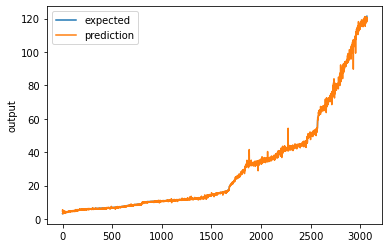

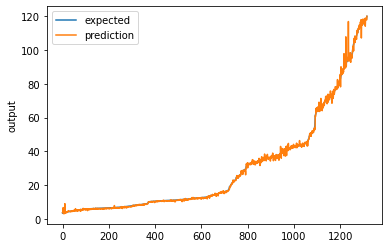

In [61]:
SEQUENCE_SIZE = 7
#x_lstm_seq_test,y_lstm_seq_test = to_sequences(SEQUENCE_SIZE,X_test,y_test)
x_lstseq, y_lstseq = to_sequences(SEQUENCE_SIZE, x, y)

#print("Shape of x_test: {}".format(x_lstm_seq_test.shape))
print("Shape of x_lstseq: {}".format(x_lstseq.shape))
#print("Shape of y_test: {}".format(y_lstm_seq_test.shape))
print("Shape of y_lstseq: {}".format(y_lstseq.shape))

#reshaping the array size
x_newseq=x_lstseq.reshape(4385,35)


#SPLIT DATA INTO TRAIN AND TEST AS 70 AND 30
x_train, x_test, y_train, y_test = train_test_split(x_newseq, y_lstseq, test_size=0.3, random_state=0)
print("Shape of x_train :{}".format(x_train.shape))
print("Shape of x_test  :{}".format(x_test.shape))

print("Shape of y_train :{}".format(y_train.shape))
print("Shape of y_test  :{}".format(y_test.shape))

type(x_test),type(y_test),type(x_train),type(y_train)

print("model trained for 7  days")
print("Optimizer  used:  adam , Activation Function used :relu  \n")
        
model = Sequential()
model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')        

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights_NN.hdf5", verbose=0, save_best_only=True)

model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=200)
model.load_weights('best_weights_NN.hdf5')
        
pred_train = model.predict(x_train)
score_train = np.sqrt(metrics.mean_squared_error(pred_train,y_train))
print("Score_train (RMSE): {}".format(score_train))

pred_test = model.predict(x_test)
score_test = np.sqrt(metrics.mean_squared_error(pred_test,y_test))
print("Score_test (RMSE): {}".format(score_test))

    
#chart_regression(pred.flatten(),y_lstseqtest, sort=True)
chart_regression(pred_train.flatten(),y_train, sort=True)
chart_regression(pred_test.flatten(),y_test, sort=True) 
    

Shape of x_lstseq: (4386, 6, 1, 5)
Shape of y_lstseq: (4386,)
Shape of x_train :(3070, 30)
Shape of x_test  :(1316, 30)
Shape of y_train :(3070,)
Shape of y_test  :(1316,)
model trained for 6 days
Optimizer  used:  adam , Activation Function used :relu  

Train on 3070 samples, validate on 1316 samples
Epoch 1/200
3070/3070 - 2s - loss: 966.0283 - val_loss: 161.6803
Epoch 2/200
3070/3070 - 0s - loss: 127.2196 - val_loss: 102.4444
Epoch 3/200
3070/3070 - 0s - loss: 65.9997 - val_loss: 41.7199
Epoch 4/200
3070/3070 - 0s - loss: 21.7175 - val_loss: 15.6365
Epoch 5/200
3070/3070 - 0s - loss: 7.0048 - val_loss: 6.9120
Epoch 6/200
3070/3070 - 0s - loss: 2.9450 - val_loss: 3.9688
Epoch 7/200
3070/3070 - 0s - loss: 1.9979 - val_loss: 3.0875
Epoch 8/200
3070/3070 - 0s - loss: 1.7680 - val_loss: 2.6237
Epoch 9/200
3070/3070 - 0s - loss: 1.5542 - val_loss: 2.9231
Epoch 10/200
3070/3070 - 0s - loss: 1.4069 - val_loss: 2.1332
Epoch 11/200
3070/3070 - 0s - loss: 1.5257 - val_loss: 2.0141
Epoch 12/20

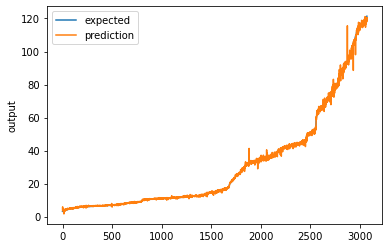

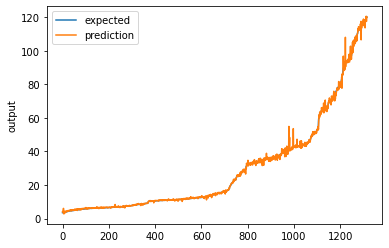

In [63]:
SEQUENCE_SIZE = 6
#x_lstm_seq_test,y_lstm_seq_test = to_sequences(SEQUENCE_SIZE,X_test,y_test)
x_lstseq, y_lstseq = to_sequences(SEQUENCE_SIZE, x, y)

#print("Shape of x_test: {}".format(x_lstm_seq_test.shape))
print("Shape of x_lstseq: {}".format(x_lstseq.shape))
#print("Shape of y_test: {}".format(y_lstm_seq_test.shape))
print("Shape of y_lstseq: {}".format(y_lstseq.shape))

#reshaping the array size
x_newseq=x_lstseq.reshape(4386,30)


x_train, x_test, y_train, y_test = train_test_split(x_newseq, y_lstseq, test_size=0.3, random_state=0)


print("Shape of x_train :{}".format(x_train.shape))
print("Shape of x_test  :{}".format(x_test.shape))

print("Shape of y_train :{}".format(y_train.shape))
print("Shape of y_test  :{}".format(y_test.shape))

type(x_test),type(y_test),type(x_train),type(y_train)

print("model trained for 6 days")
print("Optimizer  used:  adam , Activation Function used :relu  \n")

model = Sequential()
model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')        

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights_NN.hdf5", verbose=0, save_best_only=True)

model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=200)
model.load_weights('best_weights_NN.hdf5')
        
pred_train = model.predict(x_train)
score_train = np.sqrt(metrics.mean_squared_error(pred_train,y_train))
print("Score_train (RMSE): {}".format(score_train))

pred_test = model.predict(x_test)
score_test = np.sqrt(metrics.mean_squared_error(pred_test,y_test))
print("Score_test (RMSE): {}".format(score_test))

    
#chart_regression(pred.flatten(),y_lstseqtest, sort=True)
chart_regression(pred_train.flatten(),y_train, sort=True)
chart_regression(pred_test.flatten(),y_test, sort=True) 
    

Shape of x_lstseq: (4387, 5, 1, 5)
Shape of y_lstseq: (4387,)
Shape of x_train :(3070, 25)
Shape of x_test  :(1317, 25)
Shape of y_train :(3070,)
Shape of y_test  :(1317,)
model trained for 5 days
Optimizer  used:  adam , Activation Function used : relu  

Train on 3070 samples, validate on 1317 samples
Epoch 1/200
3070/3070 - 3s - loss: 1121.0200 - val_loss: 180.7581
Epoch 2/200
3070/3070 - 0s - loss: 141.2670 - val_loss: 112.6359
Epoch 3/200
3070/3070 - 0s - loss: 85.6810 - val_loss: 58.0090
Epoch 4/200
3070/3070 - 0s - loss: 35.2636 - val_loss: 19.5577
Epoch 5/200
3070/3070 - 0s - loss: 12.2193 - val_loss: 8.8735
Epoch 6/200
3070/3070 - 0s - loss: 5.4415 - val_loss: 5.2691
Epoch 7/200
3070/3070 - 0s - loss: 3.1566 - val_loss: 3.5549
Epoch 8/200
3070/3070 - 0s - loss: 2.3163 - val_loss: 3.1803
Epoch 9/200
3070/3070 - 0s - loss: 2.0302 - val_loss: 2.8105
Epoch 10/200
3070/3070 - 0s - loss: 1.8385 - val_loss: 2.6576
Epoch 11/200
3070/3070 - 0s - loss: 1.6047 - val_loss: 2.4410
Epoch 12

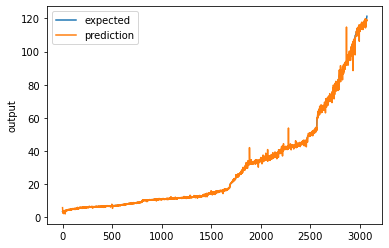

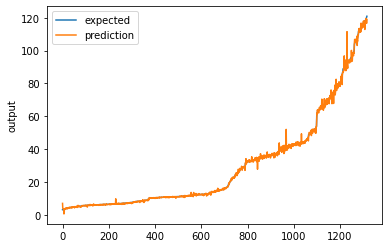

In [64]:
SEQUENCE_SIZE = 5
#x_lstm_seq_test,y_lstm_seq_test = to_sequences(SEQUENCE_SIZE,X_test,y_test)
x_lstseq, y_lstseq = to_sequences(SEQUENCE_SIZE, x, y)

#print("Shape of x_test: {}".format(x_lstm_seq_test.shape))
print("Shape of x_lstseq: {}".format(x_lstseq.shape))
#print("Shape of y_test: {}".format(y_lstm_seq_test.shape))
print("Shape of y_lstseq: {}".format(y_lstseq.shape))

#reshaping the array size
x_newseq=x_lstseq.reshape(4387,25)


x_train, x_test, y_train, y_test = train_test_split(x_newseq, y_lstseq, test_size=0.3, random_state=0)


print("Shape of x_train :{}".format(x_train.shape))
print("Shape of x_test  :{}".format(x_test.shape))

print("Shape of y_train :{}".format(y_train.shape))
print("Shape of y_test  :{}".format(y_test.shape))

type(x_test),type(y_test),type(x_train),type(y_train)

print("model trained for 5 days")
print("Optimizer  used:  adam , Activation Function used : relu  \n")
        
model = Sequential()
model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')        

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights_NN.hdf5", verbose=0, save_best_only=True)

model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=200)
model.load_weights('best_weights_NN.hdf5')
        
pred_train = model.predict(x_train)
score_train = np.sqrt(metrics.mean_squared_error(pred_train,y_train))
print("Score_train (RMSE): {}".format(score_train))

pred_test = model.predict(x_test)
score_test = np.sqrt(metrics.mean_squared_error(pred_test,y_test))
print("Score_test (RMSE): {}".format(score_test))

    
#chart_regression(pred.flatten(),y_lstseqtest, sort=True)
chart_regression(pred_train.flatten(),y_train, sort=True)
chart_regression(pred_test.flatten(),y_test, sort=True) 
    

Shape of x_lstseq: (4388, 4, 1, 5)
Shape of y_lstseq: (4388,)
Shape of x_train :(3071, 20)
Shape of x_test  :(1317, 20)
Shape of y_train :(3071,)
Shape of y_test  :(1317,)
model trained for 4 days
Optimizer  used:  adam , Activation Function used :  

Train on 3071 samples, validate on 1317 samples
Epoch 1/200
3071/3071 - 3s - loss: 1061.1044 - val_loss: 159.6302
Epoch 2/200
3071/3071 - 0s - loss: 121.8351 - val_loss: 107.7096
Epoch 3/200
3071/3071 - 0s - loss: 61.2208 - val_loss: 56.5864
Epoch 4/200
3071/3071 - 0s - loss: 19.4226 - val_loss: 20.1890
Epoch 5/200
3071/3071 - 0s - loss: 5.1975 - val_loss: 9.3560
Epoch 6/200
3071/3071 - 0s - loss: 2.4412 - val_loss: 6.3587
Epoch 7/200
3071/3071 - 0s - loss: 1.6637 - val_loss: 4.5061
Epoch 8/200
3071/3071 - 0s - loss: 1.3810 - val_loss: 4.3920
Epoch 9/200
3071/3071 - 0s - loss: 1.1694 - val_loss: 3.4212
Epoch 10/200
3071/3071 - 0s - loss: 1.1201 - val_loss: 3.6446
Epoch 11/200
3071/3071 - 0s - loss: 1.2801 - val_loss: 3.2200
Epoch 12/200
3

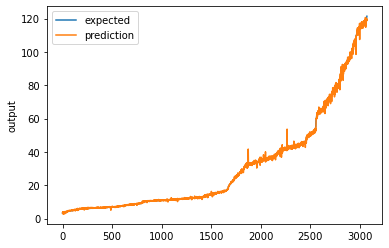

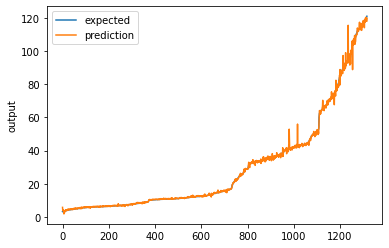

In [65]:
SEQUENCE_SIZE = 4
#x_lstm_seq_test,y_lstm_seq_test = to_sequences(SEQUENCE_SIZE,X_test,y_test)
x_lstseq, y_lstseq = to_sequences(SEQUENCE_SIZE, x, y)

#print("Shape of x_test: {}".format(x_lstm_seq_test.shape))
print("Shape of x_lstseq: {}".format(x_lstseq.shape))
#print("Shape of y_test: {}".format(y_lstm_seq_test.shape))
print("Shape of y_lstseq: {}".format(y_lstseq.shape))

#reshaping the array size
x_newseq=x_lstseq.reshape(4388,20)


x_train, x_test, y_train, y_test = train_test_split(x_newseq, y_lstseq, test_size=0.3, random_state=0)


print("Shape of x_train :{}".format(x_train.shape))
print("Shape of x_test  :{}".format(x_test.shape))

print("Shape of y_train :{}".format(y_train.shape))
print("Shape of y_test  :{}".format(y_test.shape))

type(x_test),type(y_test),type(x_train),type(y_train)

print("model trained for 4 days")
print("Optimizer  used:  adam , Activation Function used :  \n")
        
model = Sequential()
model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')        

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights_NN.hdf5", verbose=0, save_best_only=True)

model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=200)
model.load_weights('best_weights_NN.hdf5')
        
pred_train = model.predict(x_train)
score_train = np.sqrt(metrics.mean_squared_error(pred_train,y_train))
print("Score_train (RMSE): {}".format(score_train))

pred_test = model.predict(x_test)
score_test = np.sqrt(metrics.mean_squared_error(pred_test,y_test))
print("Score_test (RMSE): {}".format(score_test))

    
    #chart_regression(pred.flatten(),y_lstseqtest, sort=True)
chart_regression(pred_train.flatten(),y_train, sort=True)
chart_regression(pred_test.flatten(),y_test, sort=True) 
    

Shape of x_lstseq: (4389, 3, 1, 5)
Shape of y_lstseq: (4389,)
Shape of x_train :(3072, 15)
Shape of x_test  :(1317, 15)
Shape of y_train :(3072,)
Shape of y_test  :(1317,)
model trained for 3 days
Optimizer  used:  adam , Activation Function used :relu   

Train on 3072 samples, validate on 1317 samples
Epoch 1/200
3072/3072 - 3s - loss: 1182.8039 - val_loss: 174.9641
Epoch 2/200
3072/3072 - 0s - loss: 135.5523 - val_loss: 105.6223
Epoch 3/200
3072/3072 - 0s - loss: 79.5310 - val_loss: 54.7057
Epoch 4/200
3072/3072 - 0s - loss: 32.7530 - val_loss: 15.5709
Epoch 5/200
3072/3072 - 0s - loss: 7.6781 - val_loss: 4.5488
Epoch 6/200
3072/3072 - 0s - loss: 3.0244 - val_loss: 2.6985
Epoch 7/200
3072/3072 - 0s - loss: 2.0455 - val_loss: 1.9858
Epoch 8/200
3072/3072 - 0s - loss: 1.7381 - val_loss: 1.7873
Epoch 9/200
3072/3072 - 0s - loss: 1.5246 - val_loss: 1.8606
Epoch 10/200
3072/3072 - 0s - loss: 1.4238 - val_loss: 1.6252
Epoch 11/200
3072/3072 - 0s - loss: 1.4008 - val_loss: 1.4908
Epoch 12/

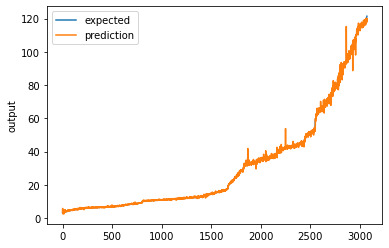

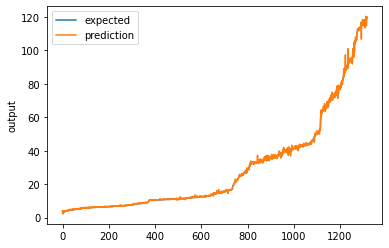

In [70]:
SEQUENCE_SIZE = 3
#x_lstm_seq_test,y_lstm_seq_test = to_sequences(SEQUENCE_SIZE,X_test,y_test)
x_lstseq, y_lstseq = to_sequences(SEQUENCE_SIZE, x, y)

#print("Shape of x_test: {}".format(x_lstm_seq_test.shape))
print("Shape of x_lstseq: {}".format(x_lstseq.shape))
#print("Shape of y_test: {}".format(y_lstm_seq_test.shape))
print("Shape of y_lstseq: {}".format(y_lstseq.shape))

#reshaping the array size
x_newseq=x_lstseq.reshape(4389,15)


x_train, x_test, y_train, y_test = train_test_split(x_newseq, y_lstseq, test_size=0.3, random_state=0)


print("Shape of x_train :{}".format(x_train.shape))
print("Shape of x_test  :{}".format(x_test.shape))

print("Shape of y_train :{}".format(y_train.shape))
print("Shape of y_test  :{}".format(y_test.shape))

type(x_test),type(y_test),type(x_train),type(y_train)

print("model trained for 3 days")
print("Optimizer  used:  adam , Activation Function used :relu   \n")
        
model = Sequential()
model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')        

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights_NN.hdf5", verbose=0, save_best_only=True)

model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=200)
model.load_weights('best_weights_NN.hdf5')
        
pred_train = model.predict(x_train)
score_train = np.sqrt(metrics.mean_squared_error(pred_train,y_train))
print("Score_train (RMSE): {}".format(score_train))

pred_test = model.predict(x_test)
score_test = np.sqrt(metrics.mean_squared_error(pred_test,y_test))
print("Score_test (RMSE): {}".format(score_test))

    
#chart_regression(pred.flatten(),y_lstseqtest, sort=True)
chart_regression(pred_train.flatten(),y_train, sort=True)
chart_regression(pred_test.flatten(),y_test, sort=True) 
    

Shape of x_lstseq: (4390, 2, 1, 5)
Shape of y_lstseq: (4390,)
Shape of x_train :(3073, 10)
Shape of x_test  :(1317, 10)
Shape of y_train :(3073,)
Shape of y_test  :(1317,)
model trained for 2 days
Optimizer  used:  adam , Activation Function used :relu

Train on 3073 samples, validate on 1317 samples
Epoch 1/200
3073/3073 - 3s - loss: 1246.6334 - val_loss: 146.7809
Epoch 2/200
3073/3073 - 0s - loss: 115.0952 - val_loss: 87.8010
Epoch 3/200
3073/3073 - 0s - loss: 53.5347 - val_loss: 30.8613
Epoch 4/200
3073/3073 - 0s - loss: 12.9339 - val_loss: 7.1465
Epoch 5/200
3073/3073 - 0s - loss: 3.8957 - val_loss: 2.9290
Epoch 6/200
3073/3073 - 0s - loss: 2.1075 - val_loss: 1.6258
Epoch 7/200
3073/3073 - 0s - loss: 1.5042 - val_loss: 1.3734
Epoch 8/200
3073/3073 - 0s - loss: 1.3909 - val_loss: 1.1493
Epoch 9/200
3073/3073 - 0s - loss: 1.2940 - val_loss: 1.1301
Epoch 10/200
3073/3073 - 0s - loss: 1.1785 - val_loss: 1.1279
Epoch 11/200
3073/3073 - 0s - loss: 1.1962 - val_loss: 0.9842
Epoch 12/200
3

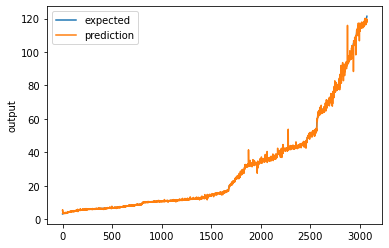

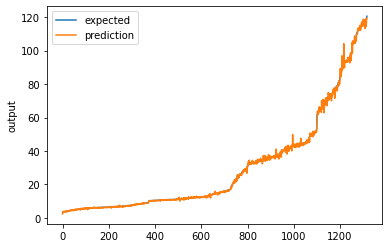

In [66]:
SEQUENCE_SIZE = 2
#x_lstm_seq_test,y_lstm_seq_test = to_sequences(SEQUENCE_SIZE,X_test,y_test)
x_lstseq, y_lstseq = to_sequences(SEQUENCE_SIZE, x, y)

#print("Shape of x_test: {}".format(x_lstm_seq_test.shape))
print("Shape of x_lstseq: {}".format(x_lstseq.shape))
#print("Shape of y_test: {}".format(y_lstm_seq_test.shape))
print("Shape of y_lstseq: {}".format(y_lstseq.shape))

#reshaping the array size
x_newseq=x_lstseq.reshape(4390,10)


x_train, x_test, y_train, y_test = train_test_split(x_newseq, y_lstseq, test_size=0.3, random_state=0)


print("Shape of x_train :{}".format(x_train.shape))
print("Shape of x_test  :{}".format(x_test.shape))

print("Shape of y_train :{}".format(y_train.shape))
print("Shape of y_test  :{}".format(y_test.shape))

type(x_test),type(y_test),type(x_train),type(y_train)

print("model trained for 2 days")
print("Optimizer  used:  adam , Activation Function used :relu\n")
        
model = Sequential()
model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')        

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights_NN.hdf5", verbose=0, save_best_only=True)

model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=200)
model.load_weights('best_weights_NN.hdf5')
        
pred_train = model.predict(x_train)
score_train = np.sqrt(metrics.mean_squared_error(pred_train,y_train))
print("Score_train (RMSE): {}".format(score_train))

pred_test = model.predict(x_test)
score_test = np.sqrt(metrics.mean_squared_error(pred_test,y_test))
print("Score_test (RMSE): {}".format(score_test))

    
    #chart_regression(pred.flatten(),y_lstseqtest, sort=True)
chart_regression(pred_train.flatten(),y_train, sort=True)
chart_regression(pred_test.flatten(),y_test, sort=True) 
    

Shape of x_lstseq: (4391, 1, 1, 5)
Shape of y_lstseq: (4391,)
Shape of x_train :(3073, 5)
Shape of x_test  :(1318, 5)
Shape of y_train :(3073,)
Shape of y_test  :(1318,)
model trained for 1 days
Optimizer  used:  adam , Activation Function used :relu 

Train on 3073 samples, validate on 1318 samples
Epoch 1/200
3073/3073 - 3s - loss: 1148.5353 - val_loss: 137.0091
Epoch 2/200
3073/3073 - 0s - loss: 74.5066 - val_loss: 53.1323
Epoch 3/200
3073/3073 - 0s - loss: 22.3720 - val_loss: 12.2544
Epoch 4/200
3073/3073 - 0s - loss: 4.4088 - val_loss: 3.3707
Epoch 5/200
3073/3073 - 0s - loss: 1.8534 - val_loss: 1.5883
Epoch 6/200
3073/3073 - 0s - loss: 1.2066 - val_loss: 1.0260
Epoch 7/200
3073/3073 - 0s - loss: 1.0366 - val_loss: 1.5752
Epoch 8/200
3073/3073 - 0s - loss: 1.1771 - val_loss: 0.9452
Epoch 9/200
3073/3073 - 0s - loss: 0.9432 - val_loss: 0.9348
Epoch 10/200
3073/3073 - 0s - loss: 0.9192 - val_loss: 1.1628
Epoch 11/200
3073/3073 - 0s - loss: 0.9402 - val_loss: 0.8982
Epoch 12/200
3073

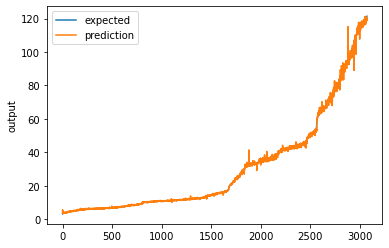

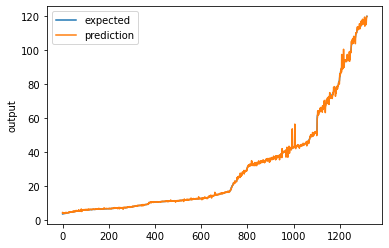

In [68]:
SEQUENCE_SIZE = 1
#x_lstm_seq_test,y_lstm_seq_test = to_sequences(SEQUENCE_SIZE,X_test,y_test)
x_lstseq, y_lstseq = to_sequences(SEQUENCE_SIZE, x, y)

#print("Shape of x_test: {}".format(x_lstm_seq_test.shape))
print("Shape of x_lstseq: {}".format(x_lstseq.shape))
#print("Shape of y_test: {}".format(y_lstm_seq_test.shape))
print("Shape of y_lstseq: {}".format(y_lstseq.shape))

#reshaping the array size
x_newseq=x_lstseq.reshape(4391,5)


x_train, x_test, y_train, y_test = train_test_split(x_newseq, y_lstseq, test_size=0.3, random_state=0)


print("Shape of x_train :{}".format(x_train.shape))
print("Shape of x_test  :{}".format(x_test.shape))

print("Shape of y_train :{}".format(y_train.shape))
print("Shape of y_test  :{}".format(y_test.shape))

type(x_test),type(y_test),type(x_train),type(y_train)

print("model trained for 1 days")
print("Optimizer  used:  adam , Activation Function used :relu \n")
        
model = Sequential()
model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')        

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights_NN.hdf5", verbose=0, save_best_only=True)

model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=200)
model.load_weights('best_weights_NN.hdf5')
        
pred_train = model.predict(x_train)
score_train = np.sqrt(metrics.mean_squared_error(pred_train,y_train))
print("Score_train (RMSE): {}".format(score_train))

pred_test = model.predict(x_test)
score_test = np.sqrt(metrics.mean_squared_error(pred_test,y_test))
print("Score_test (RMSE): {}".format(score_test))

    
#chart_regression(pred.flatten(),y_lstseqtest, sort=True)
chart_regression(pred_train.flatten(),y_train, sort=True)
chart_regression(pred_test.flatten(),y_test, sort=True) 
    